In [1]:
import tensorflow as tf
import os
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, BatchNormalization, Dropout,RandomFlip, RandomRotation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint
import pandas as pd
import shutil
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
from mpl_toolkits.axes_grid1 import ImageGrid
from tqdm.notebook import tqdm
from sklearn.metrics import roc_curve, RocCurveDisplay
from tensorflow.keras.applications import Xception 
from tensorflow.keras.applications.xception import preprocess_input


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
fp ='dataset_final'
filepath= f'drive/MyDrive/{fp}'
shutil.copytree(filepath,fp)
shutil.copy('drive/MyDrive/Capstone/Code/cnn_utils.py','cnn_utils.py')
from cnn_utils import *

In [ ]:
!nvidia-smi

Thu May 12 23:17:16 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   47C    P0    34W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
metrics = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR') # precision-recall curve
      ]

In [5]:
def show_image_grid(images,title,size=(2,2)):
  images = images.astype(int)
  fig = plt.figure(figsize=(8,8))
  grid = ImageGrid(fig, "111", size)
  for ax, x in zip(grid,images):
    ax.imshow(x)
  
  fig.suptitle(title,fontsize=28,y=1.0)
  plt.show()

def show_performance(data,model,p=0.5,gridsize=3):
  data=data.shuffle(1000).as_numpy_iterator()
  features, labels = next(data)
  features = features.astype(int)

  logits=model.predict(features)
  preds=logits>p
  preds=np.ravel(preds)

  fp = np.logical_and(preds !=labels, preds)
  fp_imgs = features[np.where(fp)]

  fn = np.logical_and(preds!=labels, np.logical_not(preds))
  fn_imgs = features[np.where(fn)]

  tp_g = np.logical_and(preds==labels,preds)
  tp_g_imgs = features[np.where(tp_g)]

  tp_h =np.logical_and(preds==labels, np.logical_not(preds))
  tp_h_imgs = features[np.where(tp_h)]
  
  while any([not(len(i) >=gridsize**2) for i in [tp_g_imgs,tp_h_imgs,fn_imgs,fp_imgs]]):
    
    features, labels = next(data)
    features = features.astype(int)

    logits=model.predict(features)
    preds=logits>p
    preds=np.ravel(preds)

    fp = np.logical_and(preds !=labels, preds)
    fp_imgs = np.concatenate([features[np.where(fp)],fp_imgs])

    fn = np.logical_and(preds!=labels, np.logical_not(preds))
    fn_imgs = np.concatenate([features[np.where(fn)],fn_imgs])

    tp_g = np.logical_and(preds==labels,preds)
    tp_g_imgs =np.concatenate([features[np.where(tp_g)],tp_g_imgs])

    tp_h =np.logical_and(preds==labels, np.logical_not(preds))
    tp_h_imgs =np.concatenate([features[np.where(tp_h)],tp_h_imgs])
  

 

  show_image_grid(fp_imgs,f'False positive images @p={p}',size=(gridsize,gridsize))
  print('\n'*4)
  show_image_grid(fn_imgs,f'False negative images @p={p}',size=(gridsize,gridsize))
  print('\n'*4)
  show_image_grid(tp_g_imgs,f'True positive images \nidentifying weapon holder @p={p}',size=(gridsize,gridsize))
  print('\n'*4)
  show_image_grid(tp_h_imgs,f'True positive images \nidentifying non weapon holder @p={p}',size=(gridsize,gridsize))




In [6]:
base_model = Xception(weights='imagenet',
         input_shape=(256,256,3),
         include_top=False)
base_model.trainable = False #freeze base model layers
aug =augment()
inputs = keras.Input(shape=(256,256,3))
x = aug(inputs)
#scale=layers.Rescaling(1./127.5, offset = -1)
x=preprocess_input(x)
x=base_model(x,training=False)
x= keras.layers.GlobalAveragePooling2D()(x)
x= Dropout(0.2)(x)
outputs = Dense(1,activation='sigmoid')(x)
model = keras.Model(inputs,outputs)
model.summary()

83697664/83683744 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 256, 256, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 256, 256, 3)      0         
 a)                                                              
                                                                 
 xception (Functional)       (None, 8, 8, 2048)        20861480  
                                                              

In [7]:
epochs = 100
model_run = '8_run1'
lr = 0.001
batch_size= 32

if not os.path.exists('drive/MyDrive/model_checkpoints'):
  os.mkdir('drive/MyDrive/model_checkpoints')

outpath = os.path.join('drive/MyDrive/model_checkpoints',model_run)
if not os.path.exists(outpath):
  os.mkdir(outpath)

callbacks = [EarlyStopping(patience = 2,restore_best_weights=True),
              ModelCheckpoint(outpath,save_best_only=True,verbose=False)]



AUTOTUNE = tf.data.AUTOTUNE
batch_size= 32
training, val = load_data(fp,batch_size)
training.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val.cache().prefetch(buffer_size=AUTOTUNE)
    
opt=Adam(learning_rate=lr)
model.summary()
model.compile(optimizer=opt,loss=tf.keras.losses.BinaryCrossentropy(),metrics=metrics)

history = model.fit(training, validation_data=val,epochs=epochs,callbacks = callbacks)






Found 5290 files belonging to 2 classes.
Using 4232 files for training.
Found 5290 files belonging to 2 classes.
Using 1058 files for validation.
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 256, 256, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 256, 256, 3)      0         
 a)                                                              
                                                                 
 xception (Functional)       (None, 8, 8, 2048)

In [21]:
training, val = load_data(fp,batch_size)


Found 5290 files belonging to 2 classes.
Using 4232 files for training.
Found 5290 files belonging to 2 classes.
Using 1058 files for validation.


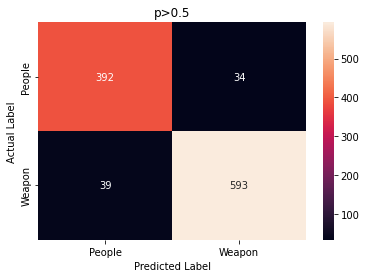

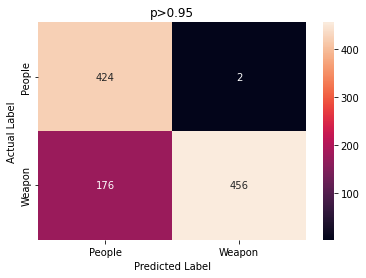

In [9]:
test_preds, test_labels = get_predictions(model,val)
plot_confusion_matrix(test_preds, test_labels)
plt.show()
plot_confusion_matrix(test_preds, test_labels,p=0.95)
plt.show()



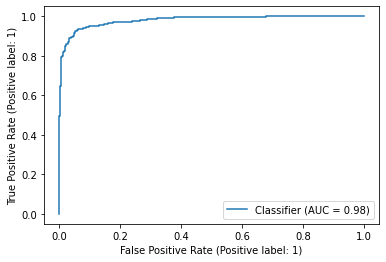

In [10]:
RocCurveDisplay.from_predictions(test_labels,test_preds)
plt.show()

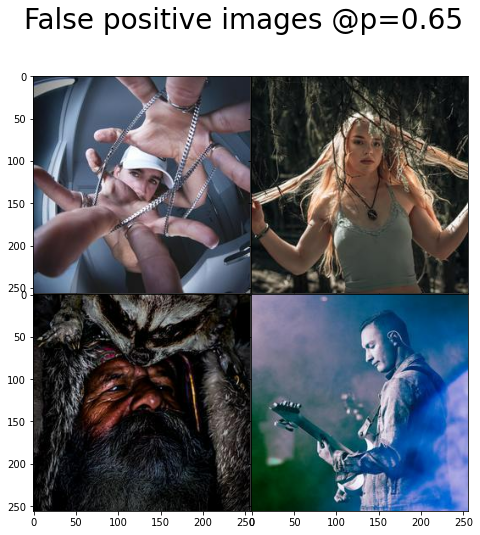

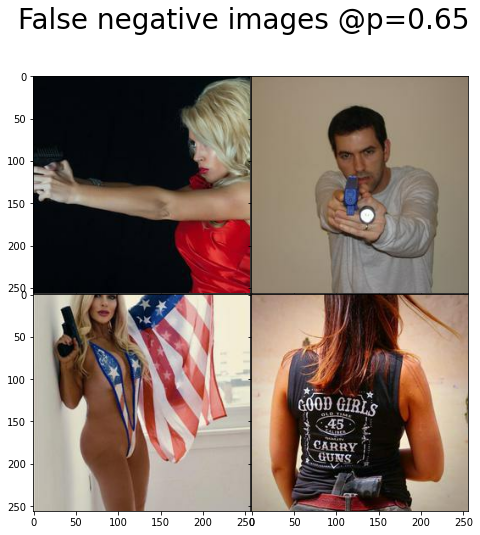

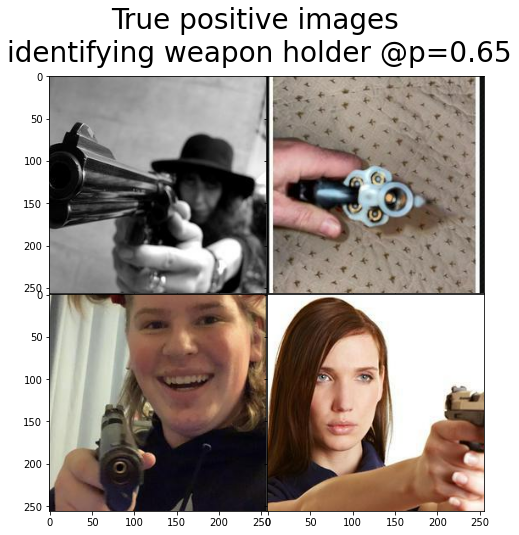

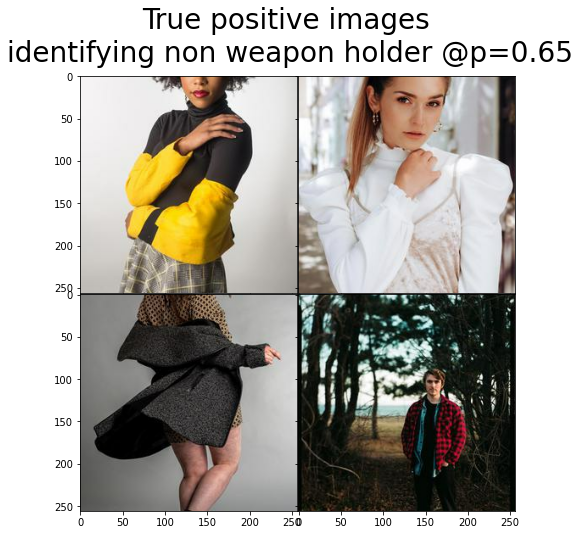

In [22]:
show_performance(val,model,p=0.65,gridsize=2)

In [16]:
model.save('drive/MyDrive/final_model')

INFO:tensorflow:Assets written to: drive/MyDrive/final_model/assets


In [ ]:
#build new notebook with saved model loading and evaluation on two external samples. 
#Also make example notebook page for model usage and model training 

###